In [1]:

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import temgymbasic.jax_components as comp
from temgymbasic.jax_utils import run_model_for_rays_and_slopes, find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv
from temgymbasic.jax_run import run_model_for_jacobians
from temgymbasic.jax_ray import Ray
import os
import tqdm.auto as tqdm
from scipy.ndimage import rotate
from scipy.ndimage import zoom

import scipy

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".0001"
%matplotlib widget
jax.config.update("jax_platform_name", "cpu")

In [2]:
def map_px_on_detector_to_scan(ScanGrid, detector_image, det_pixel_size,
                               ray_scan_coords_x, ray_scan_coords_y,
                               ray_det_coords_x, ray_det_coords_y):
    
    # When propgating backwards we need the negative of the scan rotation to be applied to the ray scan coordinates,
    # so that we can index pixels correctly on the scan grid - essentially we are rotating 
    # back into the coordinate system of the scan grid, so that a pixel at (0, 0) in the scan grid
    # represents the top left corner of the scan grid.
    scan_rotation = -ScanGrid.scan_rotation
    scan_step = ScanGrid.scan_step
    scan_shape = ScanGrid.scan_shape
    det_shape = detector_image.shape

    ray_scan_coords_y_rot = np.cos(scan_rotation) * ray_scan_coords_y - np.sin(scan_rotation) * ray_scan_coords_x
    ray_scan_coords_x_rot = np.sin(scan_rotation) * ray_scan_coords_y + np.cos(scan_rotation) * ray_scan_coords_x

    # Convert ray coordinates to pixel indices on the scan.
    scan_pixel_xs = ray_scan_coords_x_rot / scan_step[1] + scan_shape[1] / 2
    scan_pixel_ys = ray_scan_coords_y_rot / scan_step[0] + scan_shape[0] / 2
    scan_pixel_xs = np.round(scan_pixel_xs).astype(np.int32)
    scan_pixel_ys = np.round(scan_pixel_ys).astype(np.int32)

    mask = (scan_pixel_xs >= 0) & (scan_pixel_xs < scan_shape[1]) & (scan_pixel_ys >= 0) & (scan_pixel_ys < scan_shape[0])

    # Convert ray coordinates to pixel indices in the detector image.
    det_pixel_xs = ray_det_coords_x / det_pixel_size + det_shape[1] / 2
    det_pixel_ys = ray_det_coords_y / det_pixel_size + det_shape[0] / 2
    det_pixel_xs = np.round(det_pixel_xs).astype(np.int32)
    det_pixel_ys = np.round(det_pixel_ys).astype(np.int32)

    # Gather the detector pixel intensities
    detector_vals = detector_image[(det_pixel_ys, det_pixel_xs)]
    
    return scan_pixel_xs[mask], scan_pixel_ys[mask], detector_vals[mask]  


def map_px_on_scan_to_detector(Detector, sample_interpolant, 
                               ray_scan_coords_x, ray_scan_coords_y,
                               ray_det_coords_x, ray_det_coords_y):

    det_pixel_size = Detector.pixel_size
    det_shape = Detector.shape

    # Implicit in the scan coordinates in the forward case is that they simply index a series of x and y coordinates 
    # of the scan grid, which can have any rotation. 
    scan_pts = np.stack([ray_scan_coords_y, ray_scan_coords_x], axis=-1)
    
    # These coordinates then access a sample interpolant, which can have it's own rotation 
    sample_vals = sample_interpolant(scan_pts, method='nearest')

    # Convert ray coordinates to pixel indices in the detector image.
    det_pixel_xs = (ray_det_coords_x / det_pixel_size) + det_shape[1] / 2
    det_pixel_ys = (ray_det_coords_y / det_pixel_size) + det_shape[0] / 2
    
    det_pixel_xs = np.round(det_pixel_xs).astype(np.int32)
    det_pixel_ys = np.round(det_pixel_ys).astype(np.int32)
    
    return det_pixel_xs, det_pixel_ys, sample_vals


In [3]:
@jax.jit
def get_transfer_matrices(model, scan_pos_m):

    # Unpack model components.
    InputPlane = model[0]
    ScanGrid = model[1]
    Descanner = model[2]
    Detector = model[3]

    descan_error = Descanner.descan_error
    scan_y, scan_x = scan_pos_m[0], scan_pos_m[1]

    # Prepare input ray position for this scan point.
    input_ray_positions = jnp.array([scan_x, scan_y, 0.0, 0.0, 1.0])

    ray = Ray(
        z=InputPlane.z,
        matrix=input_ray_positions,
        amplitude=jnp.ones(1),
        pathlength=jnp.zeros(1),
        wavelength=jnp.ones(1),
        blocked=jnp.zeros(1, dtype=float)
    )

    # Create a new Descanner with the current scan offsets.
    new_Descanner = comp.Descanner(
        z=ScanGrid.z,
        descan_error=descan_error,
        offset_x=scan_x,
        offset_y=scan_y
    )

    current_model = [InputPlane, ScanGrid, new_Descanner, Detector]

    transfer_matrices = run_model_for_jacobians(ray, current_model)
    total_transfer_matrix = transfer_matrices[-1]
    for tm in reversed(transfer_matrices[:-1]):
        total_transfer_matrix = total_transfer_matrix @ tm
    
    return transfer_matrices

def project_frame_forwards(model, detector_frame, sample_interpolant, scan_pos, detector_coords_yx):

    # Unpack model components.
    InputPlane = model[0]
    Detector = model[3]

    semi_conv = InputPlane.semi_conv

    transfer_matrices = get_transfer_matrices(model, scan_pos).block_until_ready()

    # Prepare the transfer matrices for the system
    total_transfer_matrix = transfer_matrices[-1]
    for tm in reversed(transfer_matrices[:-1]):
        total_transfer_matrix = total_transfer_matrix @ tm
    sample_to_detector = transfer_matrices[2] @ transfer_matrices[1]
    detector_to_sample = np.linalg.inv(sample_to_detector)

    # Find all input slopes for a max semiconvergence angle that will hit the detector pixels
    input_slopes = find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(
        detector_coords_yx, scan_pos, semi_conv, total_transfer_matrix
    )

    # Run the model for the ray coordinates
    coords = run_model_for_rays_and_slopes(transfer_matrices, input_slopes, scan_pos)

    #Stack them, and perform the matrix multiplication to get the sample coordinates
    xs, ys, dxs, dys = coords
    detector_rays = np.stack([xs[-1], ys[-1], dxs[-1], dys[-1], np.ones_like(xs[-1])])
    sample_rays = np.dot(detector_to_sample, detector_rays)

    # Unpack the sample and detector ray coordinates
    sample_rays_x = sample_rays[0]
    sample_rays_y = sample_rays[1]
    det_rays_x = detector_rays[0]
    det_rays_y = detector_rays[1]

    det_x_px, det_y_px, sample_intensity = map_px_on_scan_to_detector(Detector, sample_interpolant,
                                                                      sample_rays_x, sample_rays_y,
                                                                      det_rays_x, det_rays_y)
    
    detector_frame[det_y_px, det_x_px] = sample_intensity

    return detector_frame

def project_frame_backwards(model, detector_frame, scan_pos, detector_coords_yx):

    # Unpack model components.
    InputPlane = model[0]
    ScanGrid = model[1]
    Detector = model[3]

    det_pixel_size = Detector.pixel_size
    semi_conv = InputPlane.semi_conv

    transfer_matrices = get_transfer_matrices(model, scan_pos).block_until_ready()

    # Prepare the transfer matrices for the system
    total_transfer_matrix = transfer_matrices[-1]
    for tm in reversed(transfer_matrices[:-1]):
        total_transfer_matrix = total_transfer_matrix @ tm
    sample_to_detector = transfer_matrices[2] @ transfer_matrices[1]
    detector_to_sample = np.linalg.inv(sample_to_detector)

    # Find all input slopes for a max semiconvergence angle that will hit the detector pixels
    input_slopes = find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(
        detector_coords_yx, scan_pos, semi_conv, total_transfer_matrix
    )

    # Run the model for the ray coordinates
    coords = run_model_for_rays_and_slopes(transfer_matrices, input_slopes, scan_pos)

    #Stack them, and perform the matrix multiplication to get the sample coordinates
    xs, ys, dxs, dys = coords
    detector_rays = np.stack([xs[-1], ys[-1], dxs[-1], dys[-1], np.ones_like(xs[-1])])
    sample_rays = np.dot(detector_to_sample, detector_rays)

    # Unpack the sample and detector ray coordinates
    sample_rays_x = sample_rays[0]
    sample_rays_y = sample_rays[1]
    det_rays_x = detector_rays[0]
    det_rays_y = detector_rays[1]

    sample_x_px, sample_y_px, detector_intensity = map_px_on_detector_to_scan(ScanGrid, detector_frame, det_pixel_size,
                                                                              sample_rays_x, sample_rays_y,
                                                                              det_rays_x, det_rays_y)
    
    shifted_sum = np.zeros(ScanGrid.scan_shape)

    np.add.at(shifted_sum, (sample_y_px, sample_x_px), detector_intensity)

    return shifted_sum



In [4]:
import scipy.interpolate


fourdstem_data = np.load('fourdstem_overfocused.npy')
fourdstem_data_flatnav = fourdstem_data.reshape(-1, *fourdstem_data.shape[2:])

sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape

#This is something we can never access in the reverse model, 
# but we can use it to make rotation of an image on the detector possible in the forward model
sample_rotation = 0

sample_image = np.array(sample_image, dtype=np.complex64)
sample_px_size = 0.0001
sample_rotated = rotate(sample_image, sample_rotation, reshape=True, cval=1.0)
sample_rotated_edge_length_x = sample_rotated.shape[1] * sample_px_size
sample_rotated_edge_length_y = sample_rotated.shape[0] * sample_px_size

sample_coords_x = np.linspace(-sample_rotated_edge_length_x / 2, sample_rotated_edge_length_x / 2, sample_rotated.shape[1])
sample_coords_y = np.linspace(-sample_rotated_edge_length_y / 2, sample_rotated_edge_length_y / 2, sample_rotated.shape[0])

sample_interpolant = scipy.interpolate.RegularGridInterpolator(
    (sample_coords_y, sample_coords_x), sample_rotated, fill_value=1.0, bounds_error=False
)

Text(0.5, 1.0, 'Interpolated Sample Image')

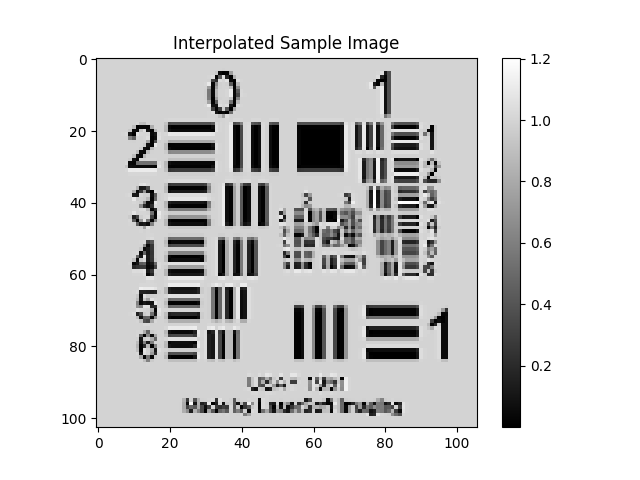

In [5]:
interpolant_image = sample_interpolant(np.stack(np.meshgrid(sample_coords_y, sample_coords_x, indexing='ij'), axis=-1))

plt.figure()
plt.imshow(np.abs(interpolant_image), cmap='gray')
plt.colorbar()
plt.title('Interpolated Sample Image')


In [6]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 
# Axx, Ayy, Cxx, Cyy = 4, 3, -5, -4 # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
# Axy, Ayx, Cxy, Cyx = 6, -7, -3, 5 # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix
Axx, Ayy, Cxx, Cyy = 1, 1, 0, 0
Axy, Ayx, Cxy, Cyx = 0, 0, 0, 0

descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]

#Set up the parameters for the simulation
defocus = 0.01
semi_conv = 0.05
camera_length = 1.0
scan_size = sample_image_shape
det_size = (64, 64)
scan_step_yx = (0.0001, 0.0001)
det_px_size= 0.002
scan_rotation = 45

params_dict = {
    'defocus': defocus,
    'semi_conv': semi_conv,
    'camera_length': camera_length,
    'scan_size': scan_size,
    'det_size': det_size,
    'scan_px_size': scan_step_yx,
    'det_px_size': det_px_size,
    'scan_rotation': scan_rotation,
    'descan_error': descan_error
}

#Create ray input z plane
crossover_z = jnp.zeros((1))

InputPlane = comp.InputPlane(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_px_size'], scan_shape=params_dict['scan_size'], scan_rotation=params_dict['scan_rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=det_size, pixel_size=params_dict['det_px_size'], rotation=0.0)
model = [InputPlane, ScanGrid, Descanner, Detector]

Scan rotation and Sample rotation demonstration

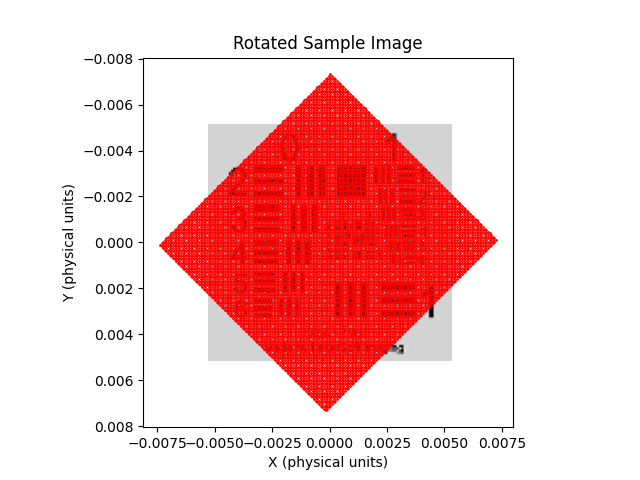

In [7]:
scan_coordinates = ScanGrid.get_coords()

# Set the physical extent (edges) centered around zero
extent = [
    -sample_rotated_edge_length_x/2,
    sample_rotated_edge_length_x/2,
    sample_rotated_edge_length_y/2,
    -sample_rotated_edge_length_y/2,
]

# Reshape the scan coordinates into a 2D grid (centers of pixels).
grid = scan_coordinates.reshape(ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], 2)

plt.figure()
plt.imshow(np.abs(sample_rotated), cmap='gray', extent=extent)
plt.plot(grid[:, :, 1], grid[:, :, 0], 'ro', markersize=1)

plt.title('Rotated Sample Image')
plt.xlabel('X (physical units)')
plt.ylabel('Y (physical units)')
plt.show()

Generating the forward dataset:

In [8]:
fourdstem_array = np.zeros((*ScanGrid.scan_shape, *Detector.shape), dtype=np.complex64)

detector_coords_yx = Detector.get_coords()
scan_coords_yx = ScanGrid.get_coords()
scan_coords_yx = scan_coords_yx.reshape(*ScanGrid.scan_shape, 2)

for scan_idx_y in tqdm.trange(fourdstem_array.shape[0]):
    for scan_idx_x in range(fourdstem_array.shape[1]):
        det_frame = np.zeros(Detector.shape, dtype=np.complex64)
        fourdstem_array[scan_idx_y, scan_idx_x] = project_frame_forwards(model, det_frame, sample_interpolant, scan_coords_yx[scan_idx_y, scan_idx_x], detector_coords_yx)


  0%|          | 0/103 [00:00<?, ?it/s]

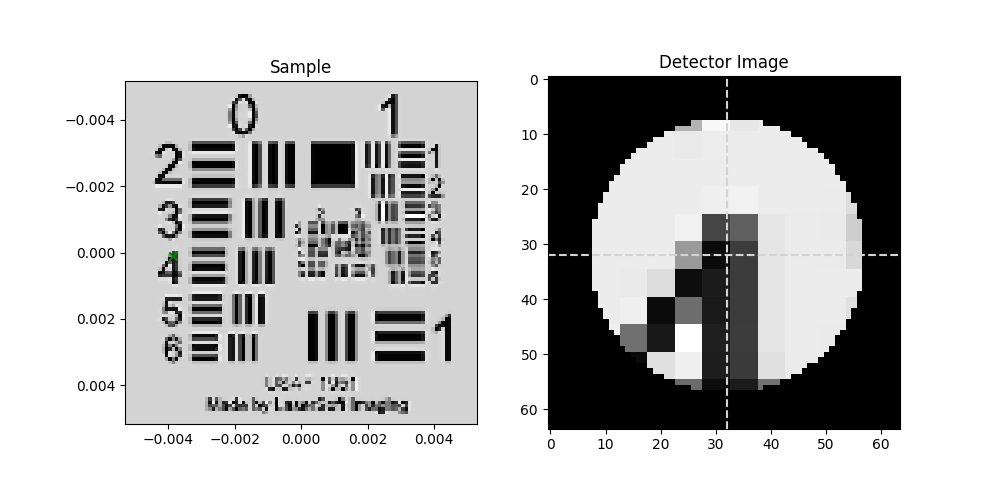

In [9]:
scan_idx_y, scan_idx_x = 25, 25
scan_pos_y, scan_pos_x = scan_coords_yx[scan_idx_y, scan_idx_x]
det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.abs(sample_rotated), extent=extent, cmap='gray')
ax[0].scatter(scan_pos_x, scan_pos_y, c='g', marker='x', alpha=1)
# ax[0].plot(grid[:, :, 1], grid[:, :, 0], 'ro', markersize=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(Detector.shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(Detector.shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

In [10]:
shifted_sum = np.zeros(ScanGrid.scan_shape)

for scan_idx_y in tqdm.trange(fourdstem_data.shape[0]):
    for scan_idx_x in range(fourdstem_data.shape[1]):
        det_frame = fourdstem_data[scan_idx_y, scan_idx_x]
        shifted_sum += project_frame_backwards(model, det_frame, scan_coords_yx[scan_idx_y, scan_idx_x], detector_coords_yx)

  0%|          | 0/103 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Shifted Sum Image')

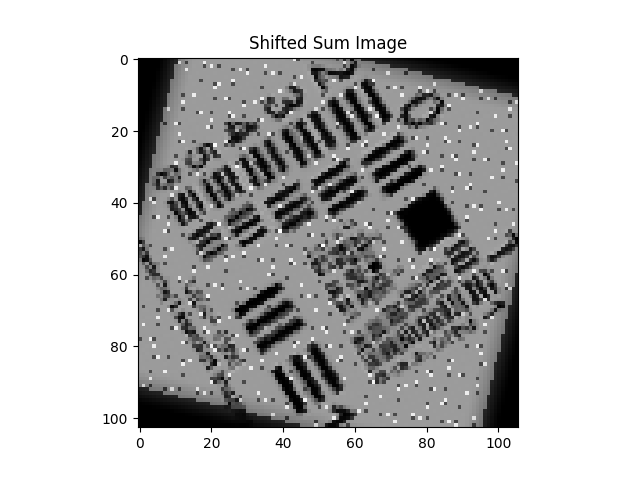

In [15]:
plt.figure()
plt.imshow(np.abs(shifted_sum), cmap='gray')
plt.title('Shifted Sum Image')

In [12]:
# %load_ext line_profiler
# %lprun -f project_frame -f map_px_on_detector_to_sample project_frame(model, frame, scan_idx, detector_coords_yx)

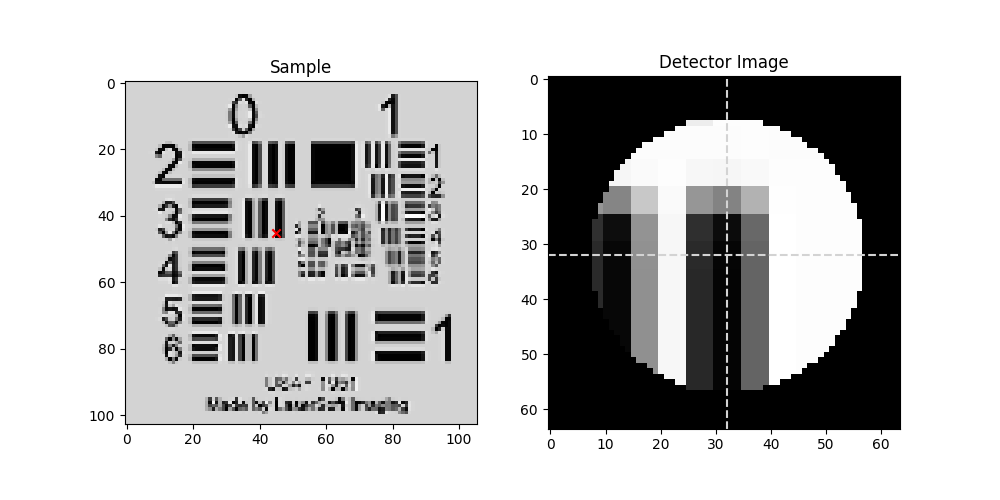

In [13]:
scan_idx_x, scan_idx_y = 45, 45
det_image_selected = fourdstem_data[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(sample_image), 
             cmap='gray')
ax[0].scatter(scan_idx_x, scan_idx_y, c='r', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(det_image_selected.shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(det_image_selected.shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

NameError: name 'data' is not defined

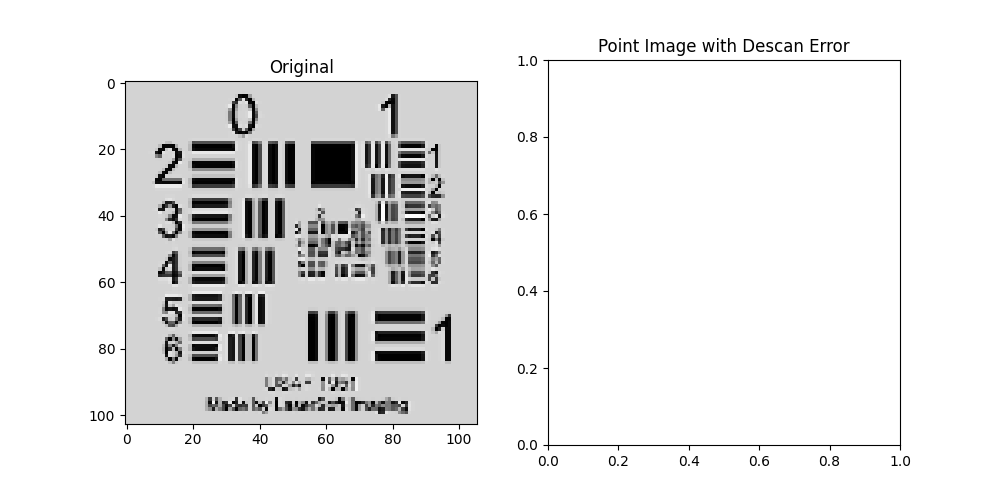

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title('Original')
axes[0].imshow(np.abs(sample_image), cmap='gray')
axes[1].set_title('Point Image with Descan Error')
axes[1].imshow(np.abs(data[:, :, det_image_selected.shape[0]//2, det_image_selected.shape[1]//2]), cmap='gray')

In [ ]:
InputPlane = comp.InputPlane(z=crossover_z)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), pixel_size=params_dict['scan_px_size'], shape=params_dict['scan_size'], rotation=params_dict['rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=det_size, pixel_size=params_dict['det_px_size'])
model = [InputPlane, ScanGrid, Descanner, Detector]

input_ray_positions = jnp.array([[0.0, 0.0, 0.0, 0.0, 1.0]])

ray = Ray(
    z=jnp.array([0.0]),
    matrix=input_ray_positions,
    amplitude=jnp.ones(1),
    pathlength=jnp.zeros(1),
    wavelength=jnp.ones(1),
    blocked=jnp.zeros(1, dtype=float)
)

In [ ]:
num_scan_positions = scan_size[0] * scan_size[1]
each_ABCD = run_model_for_jacobians(ray, model)
total_ABCD = each_ABCD[-1] @ each_ABCD[-2] @ each_ABCD[-3] @ each_ABCD[-4]
detector_coords_yx = Detector.get_coords()
scan_pos = jnp.array([scan_idx_y, scan_idx_x])
input_slopes = find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(
    detector_coords_yx, scan_pos, semi_conv, total_ABCD[0]
)
coords = run_model_for_rays_and_slopes(each_ABCD, input_slopes, scan_pos)

xs, ys, dxs, dys = coords

detector_rays = jnp.stack([xs[-1], ys[-1], dxs[-1], dys[-1], jnp.ones_like(xs[-1])])
sample_rays = jnp.dot(total_ABCD[0], detector_rays)
sample_rays_x = sample_rays[0]
sample_rays_y = sample_rays[1]
det_rays_x = detector_rays[0]
det_rays_y = detector_rays[1]
sample_image_selected = fourdstem_sample_array[scan_idx_y, scan_idx_x]


shifted_sum_image = get_shifted_sum(model, data, fourdstem_sample_array, semi_conv)

In [ ]:
# run_model_for_jacobians_stats = %timeit -o run_model_for_jacobians(ray, model).block_until_ready()
# find_input_slopes_stats = %timeit -o find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(detector_coords_yx, scan_pos, semi_conv, total_ABCD[0]).block_until_ready()
# run_model_for_rays_and_slopes_stats = %timeit -o run_model_for_rays_and_slopes(each_ABCD, input_slopes, scan_pos).block_until_ready()
# map_px_on_detector_to_sample_stats = %timeit -o map_px_on_detector_to_sample(sample_image_selected, det_image_selected, scan_px_size, det_px_size,sample_rays_x, sample_rays_y,det_rays_x, det_rays_y).block_until_ready()


In [ ]:
# print(f"Run Model For Jacobians Total Time for all scan positions: {run_model_for_jacobians_stats.best * num_scan_positions:.4f} seconds")
# print(f"Find Input Slopes Total Time for all scan positions: {find_input_slopes_stats.best * num_scan_positions:.4f} seconds")
# print(f"Run Model For Rays and Slopes Total Time for all scan positions: {run_model_for_rays_and_slopes_stats.best * num_scan_positions:.4f} seconds")
# print(f"Map Px on Det Time for all scan positions: {map_px_on_detector_to_sample_stats.best * num_scan_positions:.4f} seconds")


In [ ]:
# %timeit get_shifted_sum(model, data, fourdstem_sample_array, semi_conv).block_until_ready()

NameError: name 'shifted_sum_image' is not defined

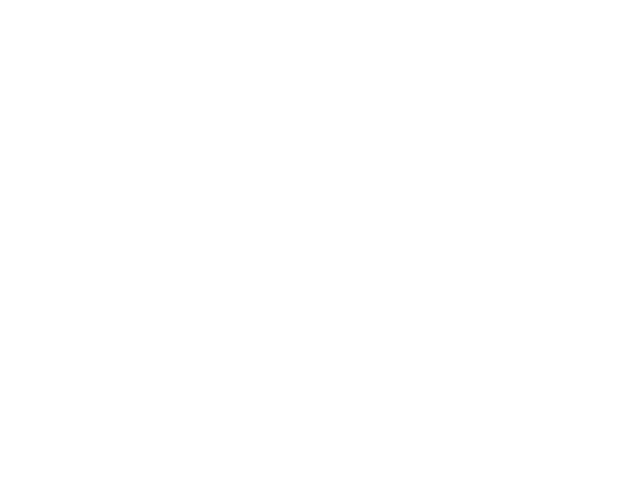

In [ ]:
import panel as pn
pn.extension()

In [ ]:
from libertem_ui.live_plot import ApertureFigure
from bokeh.models.formatters import PrintfTickFormatter

shifted_sum_array = np.random.uniform(size=det_size)

def run_model_inner(params_dict):
    defocus = params_dict['defocus']
    semi_conv = params_dict['semi_conv']
    camera_length = params_dict['camera_length']
    scan_size = params_dict['scan_size']
    det_size = params_dict['det_size']
    scan_px_size = params_dict['scan_px_size']
    det_px_size = params_dict['det_px_size']
    rotation = params_dict['rotation']
    descan_error = params_dict['descan_error']

    
    InputPlane = comp.InputPlane(z=crossover_z)
    ScanGrid = comp.ScanGrid(z=jnp.array([defocus]), pixel_size=scan_px_size, shape=sample_image_shape)
    Rotator = comp.Rotator(z=jnp.array([defocus]), angle=rotation)
    Descanner = comp.Descanner(z=jnp.array([defocus]), descan_error=descan_error, offset_x=0.0, offset_y=0.0)
    Detector = comp.Detector(z=jnp.array([camera_length]), shape=det_size, pixel_size=det_px_size)
    model = [InputPlane, ScanGrid, Descanner, Detector]


    shifted_sum_image = get_shifted_sum(model, data, fourdstem_sample_array, semi_conv)

    return np.abs(shifted_sum_image)


defocus_slider = pn.widgets.FloatSlider(name="defocus", value=0.001, start=0.001, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f m'))
semi_conv_slider = pn.widgets.FloatSlider(name="semi_conv", value=0.01, start=0.01, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f slope'))
camera_length_slider = pn.widgets.FloatSlider(name="camera_length", value=1.0, start=0.1, end=10, format=PrintfTickFormatter(format='%.3f m'))
scan_px_size_slider = pn.widgets.FloatSlider(name="scan_px_size", value=0.0001, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
det_px_size_slider = pn.widgets.FloatSlider(name="det_px_size", value=.002, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
rotation_slider = pn.widgets.FloatSlider(name="rotation", start=0., end=360, step=0.01, value=0.02, format=PrintfTickFormatter(format='%.3f degrees'))

Axx_slider = pn.widgets.FloatSlider(name="Axx", value=4, start=-10, end=10, step=0.1)
Axy_slider = pn.widgets.FloatSlider(name="Axy", value=6, start=-10, end=10, step=0.1)
Ayx_slider = pn.widgets.FloatSlider(name="Ayx", value=-7, start=-10, end=10, step=0.1)
Ayy_slider = pn.widgets.FloatSlider(name="Ayy", value=3, start=-10, end=10, step=0.1)
Cxx_slider = pn.widgets.FloatSlider(name="Cxx", value=-5, start=-10, end=10, step=0.1)
Cxy_slider = pn.widgets.FloatSlider(name="Cxy", value=-3, start=-10, end=10, step=0.1)
Cyx_slider = pn.widgets.FloatSlider(name="Cyx", value=5, start=-10, end=10, step=0.1)
Cyy_slider = pn.widgets.FloatSlider(name="Cyy", value=-4, start=-10, end=10, step=0.1)

figure = (
    ApertureFigure
    .new(shifted_sum_array, tools=False, maxdim=600)
)


def run_model(*e):
    defocus_v = defocus_slider.value
    semi_conv_v = semi_conv_slider.value
    camera_length_v = camera_length_slider.value
    scan_px_size_v = scan_px_size_slider.value
    det_px_size_v = det_px_size_slider.value
    rotation_v = rotation_slider.value

    descan_error_v = [Axx_slider.value, Axy_slider.value, Ayx_slider.value, Ayy_slider.value, 
                      Cxx_slider.value, Cxy_slider.value, Cyx_slider.value, Cyy_slider.value]

    params_dict = {
        'defocus': defocus_v,
        'semi_conv': semi_conv_v,
        'camera_length': camera_length_v,
        'scan_size': sample_image_shape,
        'det_size': det_size,
        'scan_px_size': scan_px_size_v,
        'det_px_size': det_px_size_v,
        'rotation': rotation_v,
        'descan_error': descan_error_v}

    image = run_model_inner(params_dict)
    figure.im.update(image)


defocus_slider.param.watch(run_model, 'value_throttled')
semi_conv_slider.param.watch(run_model, 'value_throttled')
camera_length_slider.param.watch(run_model, 'value_throttled')
scan_px_size_slider.param.watch(run_model, 'value_throttled')
det_px_size_slider.param.watch(run_model, 'value_throttled')
rotation_slider.param.watch(run_model, 'value_throttled')
Axx_slider.param.watch(run_model, 'value_throttled')
Axy_slider.param.watch(run_model, 'value_throttled')
Ayx_slider.param.watch(run_model, 'value_throttled')
Ayy_slider.param.watch(run_model, 'value_throttled')
Cxx_slider.param.watch(run_model, 'value_throttled')
Cxy_slider.param.watch(run_model, 'value_throttled')
Cyx_slider.param.watch(run_model, 'value_throttled')
Cyy_slider.param.watch(run_model, 'value_throttled')

pn.Row(
    pn.Column(
        defocus_slider,
        semi_conv_slider,
        camera_length_slider,
        scan_px_size_slider,
        det_px_size_slider,
        rotation_slider,
        pn.Row(
            pn.Column(
                Axx_slider,
                Axy_slider,
                Ayx_slider,
                Ayy_slider
            ),
            pn.Column(
                Cxx_slider,
                Cxy_slider,
                Cyx_slider,
                Cyy_slider
            )
        )
    ),
    figure.layout
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7d9f542d-469b-4e48-8674-df9542ca32bd': {'version…